<hr>
<h1><center>Web Traffic Time Series Forecasting</center></h1>
<hr>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.seasonal import seasonal_decompose

### Reading Data

In [2]:
train = pd.read_csv('./train_2.csv')
print("Train data shape is ",train.shape)

Train data shape is  (145063, 804)


In [3]:
def plot_barplots(data, title, yname, xname):
    """
    function to plot barplots for the data containing categorywise count
    """
    plt.figure(figsize=(12,4))
    sns.barplot(data.index, data.values)
    plt.title(title)
    plt.ylabel(yname, fontsize=12)
    plt.xlabel(xname, fontsize=12)
    plt.show()
    
def plot_timeseries(data, header, rotate=0, size=(15,5)):
    """
    plots the time series plot of the given data
    Inputs are :
    data       : time series data
    header     : This is string which we want at the top of the plot
    xtick_dict : dictionary contining key:value combo where key are labels and values are xtick locations
    size       : size of the plot
    """
    ticks      = [ x for x in list(enumerate(data.index)) if x[1].endswith=='01' ]
    ticklabel  = [ x[1] for x in ticks ]
    tickloc    = [ x[0] for x in ticks ]
    
    fig = plt.figure(figsize=size)
    plt.title(header)
    b1 = plt.plot(np.arange(len(data.index)), data)
    plt.xticks(tickloc, ticklabel, rotation=rotate)
    plt.legend()
    plt.grid()
    plt.show()

In [4]:
print("Shape of data is :: Rows={0} and Columnd={1}.".format(train.shape[0], train.shape[1]))

print("\n\nTrain dataset looks like : \n")
train.head(5)

Shape of data is :: Rows=145063 and Columnd=804.


Train dataset looks like : 



,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


<p>Data contains page name and its corresponding pageviews as features for the given date. Also, there are NA values for some page which can be either No pageviews for that page of No data availability. Hence, we will be replace NA values with 0.</p>

In [5]:
train = train.fillna(0)
print("Train after filling all NA with 0 looks like \n")
train.head(5)

Train after filling all NA with 0 looks like 



,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [6]:
print("Understanding the data as below : ")
train.describe()

Understanding the data as below : 


,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
count,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,...,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05
mean,1.024882e+03,1.031234e+03,9.731234e+02,1.003791e+03,1.044342e+03,1.108086e+03,1.062624e+03,1.026181e+03,1.030808e+03,1.022828e+03,...,1.011168e+03,9.987457e+02,1.144761e+03,1.149787e+03,1.118070e+03,1.188133e+03,1.245881e+03,9.427261e+02,9.124278e+02,9.779472e+02
std,6.735340e+04,6.868551e+04,6.449417e+04,6.720994e+04,6.834087e+04,7.464303e+04,7.016081e+04,6.325117e+04,6.632223e+04,6.689720e+04,...,4.938129e+04,5.640392e+04,6.656530e+04,6.838497e+04,6.585679e+04,6.347205e+04,6.645265e+04,5.029841e+04,4.484142e+04,5.593653e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00,4.000000e+00,...,1.800000e+01,1.600000e+01,1.600000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.900000e+01,1.700000e+01,1.600000e+01,1.400000e+01
50%,5.800000e+01,5.700000e+01,5.400000e+01,5.500000e+01,5.900000e+01,5.900000e+01,6.100000e+01,6.300000e+01,6.100000e+01,5.900000e+01,...,1.160000e+02,1.160000e+02,1.220000e+02,1.150000e+02,1.140000e+02,1.140000e+02,1.270000e+02,1.120000e+02,1.120000e+02,1.090000e+02
75%,4.090000e+02,4.060000e+02,3.980000e+02,3.880000e+02,4.280000e+02,4.340000e+02,4.310000e+02,4.360000e+02,4.350000e+02,4.300000e+02,...,4.910000e+02,4.960000e+02,5.410000e+02,5.190000e+02,5.140000e+02,5.220000e+02,5.550000e+02,4.980000e+02,4.990000e+02,5.170000e+02
max,2.038124e+07,2.075219e+07,1.957397e+07,2.043964e+07,2.077211e+07,2.254467e+07,2.121089e+07,1.910791e+07,1.999385e+07,2.020182e+07,...,1.372256e+07,1.578888e+07,1.856151e+07,1.906250e+07,1.839517e+07,1.749919e+07,1.827305e+07,1.411666e+07,1.269626e+07,1.573111e+07


# [1] Understanding Page Names

In [7]:
page_names = train.Page
page_names.values

array(['2NE1_zh.wikipedia.org_all-access_spider',
       '2PM_zh.wikipedia.org_all-access_spider',
       '3C_zh.wikipedia.org_all-access_spider', ...,
       'Enamorándome_de_Ramón_es.wikipedia.org_all-access_spider',
       'Hasta_el_último_hombre_es.wikipedia.org_all-access_spider',
       'Francisco_el_matemático_(serie_de_televisión_de_2017)_es.wikipedia.org_all-access_spider'],
      dtype=object)

<p>Name of the page contains useful information in this data. Mainly, we can see website name present in the name along with language details. Also, in the end, we can see access category i.e. mode through which page was access and also the agent through which it was accessed.</p>

In [8]:
pageData = pd.DataFrame(page_names, columns=['Page'])
pageData['Site']      = pageData['Page'].map(lambda x:x.split('_')[-3])
pageData['Site_Name'] = pageData['Site'].map(lambda x:x.split('.')[1])
pageData['Language']  = pageData['Site'].map(lambda x:x.split('.')[0])
pageData['Access']    = pageData['Page'].map(lambda x:x.split('_')[-2])
pageData['Agent']     = pageData['Page'].map(lambda x:x.split('_')[-1])

pageData.head()

,Page,Site,Site_Name,Language,Access,Agent
0,2NE1_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,wikipedia,zh,all-access,spider
1,2PM_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,wikipedia,zh,all-access,spider
2,3C_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,wikipedia,zh,all-access,spider
3,4minute_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,wikipedia,zh,all-access,spider
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,zh.wikipedia.org,wikipedia,zh,all-access,spider


## [1.1] Site Name

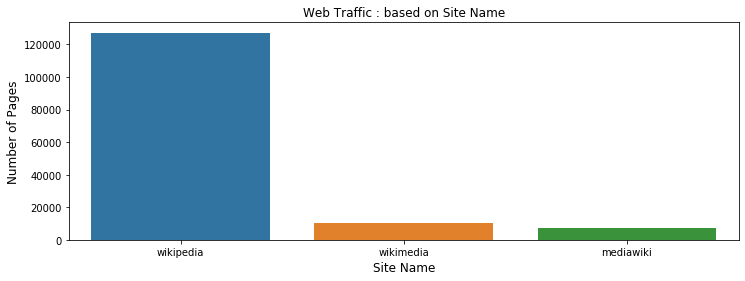

Analysis shows : 
wikipedia has total of 127208 pages.
wikimedia has total of 10555 pages.
mediawiki has total of 7300 pages.


In [9]:
#sitename
data_counts  = pageData['Site_Name'].value_counts()
plot_barplots(data_counts, 'Web Traffic : based on Site Name', 'Number of Pages', 'Site Name')
print("Analysis shows : ")
for k, v in data_counts.items():
    print("{0} has total of {1} pages.".format(k, v))

<p><li>More data is available from 'wikipedia' sites</li>
<li>Less data available from sites 'wikimedia' and 'mediawiki' respectively</li></p>

## [1.2] Site Language

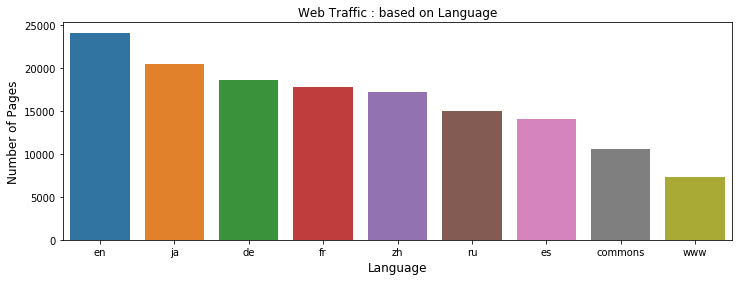

Analysis shows : 
1) en has total of 24108 pages.
2) ja has total of 20431 pages.
3) de has total of 18547 pages.
4) fr has total of 17802 pages.
5) zh has total of 17229 pages.
6) ru has total of 15022 pages.
7) es has total of 14069 pages.
8) commons has total of 10555 pages.
9) www has total of 7300 pages.


In [10]:
#language
data_counts  = pageData['Language'].value_counts()
plot_barplots(data_counts, 'Web Traffic : based on Language', 'Number of Pages', 'Language')
print("Analysis shows : ")
for i, (k, v) in enumerate(data_counts.items()):
    print("{2}) {0} has total of {1} pages.".format(k, v, i+1))

<p><li>Total of 9 languages found in page names</li>
    <li>Number of records from site containing 'English(en)' is more as it is a commonly used language everywhere</li>
</p>

## [1.3] Page Access 

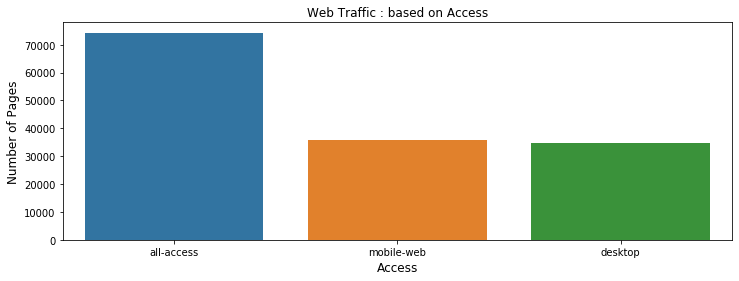

Analysis shows : 
1) all-access has total of 74315 pages.
2) mobile-web has total of 35939 pages.
3) desktop has total of 34809 pages.


In [11]:
#access
data_counts  = pageData['Access'].value_counts()
plot_barplots(data_counts, 'Web Traffic : based on Access', 'Number of Pages', 'Access')
print("Analysis shows : ")
for i, (k, v) in enumerate(data_counts.items()):
    print("{2}) {0} has total of {1} pages.".format(k, v, i+1))

<p><li>Page is mainly accessed from Three categories viz. all-access, Desktop access and Mobile-web.</li>
<li>More pages are from 'all-access' category compared to that of remaining categories</li></p>

## [1.4] Access Agent

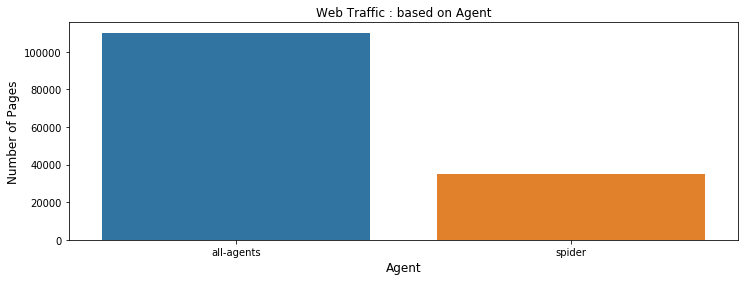

Analysis shows : 
1) all-agents has total of 110150 pages.
2) spider has total of 34913 pages.


In [12]:
#agent
data_counts  = pageData['Agent'].value_counts()
plot_barplots(data_counts, 'Web Traffic : based on Agent', 'Number of Pages', 'Agent')
print("Analysis shows : ")
for i, (k, v) in enumerate(data_counts.items()):
    print("{2}) {0} has total of {1} pages.".format(k, v, i+1))

<p><li>All-agent and Spider are two agents used for accessing page.</li>
<li>Pages with 'spider' agent is very less compared to that of 'all-agent'</li></p>

<hr> 

# [2] Understanding Time Series

In [13]:
timeseries = train.iloc[:, 1:]
timeseries.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


## [2.1] Distribution of Mean PageViews

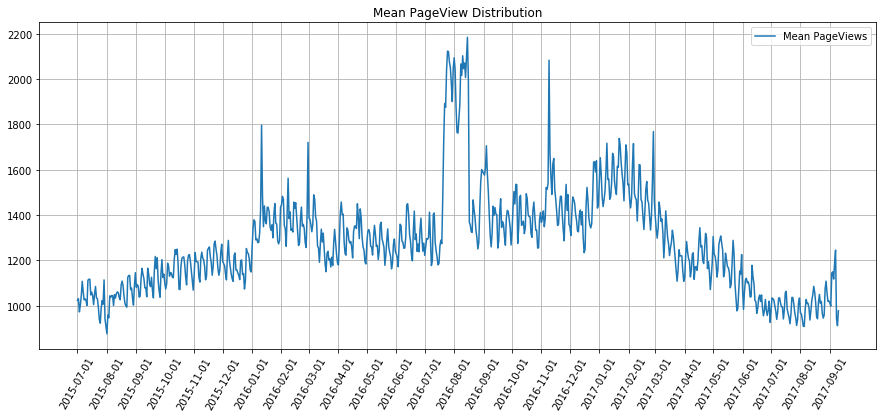

In [14]:
mean      = timeseries.mean(axis=0)
mean_diff = timeseries.diff(axis=1).mean(axis=0)

ticks      = [ x for x in list(enumerate(mean.index)) if x[1].endswith('01') ]
ticklabel  = [ x[1] for x in ticks ]
tickloc    = [ x[0] for x in ticks ]
fig = plt.figure(figsize=(15, 6))
plt.title('Mean PageView Distribution')
b1 = plt.plot(np.arange(len(mean.index)), mean)
#b2 = plt.plot(np.arange(len(mean_diff.index)), mean_diff)
plt.xticks(tickloc, ticklabel, rotation=60)
#plt.legend([b1[0], b2[0]], ['Mean PageViews', '1st Oder Diff'])
plt.legend([b1[0]], ['Mean PageViews'])
plt.grid()
plt.show()

<p>Above is the time series graph for mean pageviews for all pages. This graph can tell us, the data is not stationary over time also the same is not showing some combining effect of time, i.e. strict increase in pageviews with increase in time</p>
<p>Even though the data is not so ideal, we can still check if the same is correlated with itself by plotting Autocorrelation plot as below</p>

## [2.2] Correlation with Lagged value

#### [2.2.1] Auto-correlation of Mean PageViews

C:\Users\kaushik\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


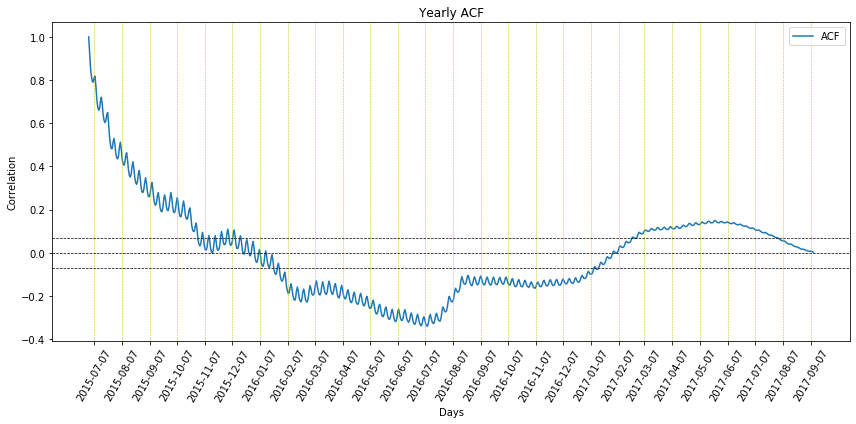

In [15]:
#acf of complete waveform
days = len(mean)

ticks      = [ x for x in list(enumerate(mean.index))[:days] if x[1].endswith('07') ]
ticklabel  = [ x[1] for x in ticks ]
tickloc    = [ x[0] for x in ticks ]

plt.figure(figsize=(12,6))
acf_plot   = acf((mean.values), nlags=days)
plt.title('Yearly ACF')
plt.xlabel('Days')
plt.ylabel('Correlation')
plt.plot(np.arange(len(acf_plot)), acf_plot, ls='-')

plt.xticks(tickloc, ticklabel, rotation=60)
plt.legend(['ACF'])
[plt.axvline(x=p, color='y', ls='--', lw=0.5) for p in tickloc]
plt.axhline(y=0,ls='--',lw=0.7, color='black')
plt.axhline(y=-1.96/np.sqrt(days),ls='--',lw=0.7, color='black')
plt.axhline(y=1.96/np.sqrt(days),ls='--' ,lw=0.7, color='black')

plt.tight_layout()
plt.show()

<p>Figure shows, ACF for the complete time series. We can clearly see that the pageviews are strongly correlated with their previous values.</p>
<p>PLotting ACF plot with different lags, to understand the correlation in depth</p>

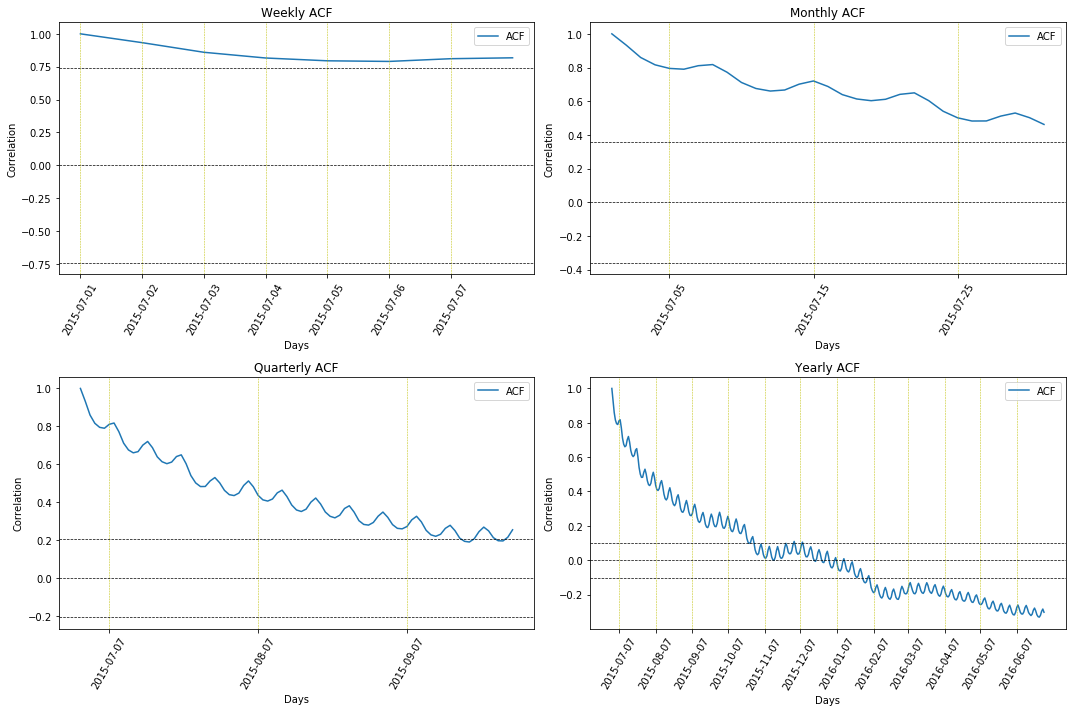

In [16]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(15, 10))


days = 7
ticks      = [ x for x in list(enumerate(mean.index))[:days] ]
ticklabel  = [ x[1] for x in ticks ]
tickloc    = [ x[0] for x in ticks ]
plt.subplot(221)
acf_plot   = acf((mean.values), nlags=days)
plt.title('Weekly ACF')
plt.xlabel('Days')
plt.ylabel('Correlation')
plt.plot(np.arange(len(acf_plot)), acf_plot, ls='-')
plt.xticks(tickloc, ticklabel, rotation=60)
plt.legend(['ACF'])
[plt.axvline(x=p, color='y', ls='--', lw=0.5) for p in tickloc]
plt.axhline(y=0,ls='--',lw=0.7, color='black')
plt.axhline(y=-1.96/np.sqrt(days),ls='--',lw=0.7, color='black')
plt.axhline(y=1.96/np.sqrt(days),ls='--' ,lw=0.7, color='black')


days = 30

ticks      = [ x for x in list(enumerate(mean.index))[:days] if x[1].endswith('5') ]
ticklabel  = [ x[1] for x in ticks ]
tickloc    = [ x[0] for x in ticks ]
plt.subplot(222)
acf_plot   = acf((mean.values), nlags=days)
plt.title('Monthly ACF')
plt.xlabel('Days')
plt.ylabel('Correlation')
plt.plot(np.arange(len(acf_plot)), acf_plot, ls='-')
plt.xticks(tickloc, ticklabel, rotation=60)
plt.legend(['ACF'])
[plt.axvline(x=p, color='y', ls='--', lw=0.5) for p in tickloc]
plt.axhline(y=0,ls='--',lw=0.7, color='black')
plt.axhline(y=-1.96/np.sqrt(days),ls='--',lw=0.7, color='black')
plt.axhline(y=1.96/np.sqrt(days),ls='--' ,lw=0.7, color='black')


days = 90

ticks      = [ x for x in list(enumerate(mean.index))[:days] if x[1].endswith('07') ]
ticklabel  = [ x[1] for x in ticks ]
tickloc    = [ x[0] for x in ticks ]
plt.subplot(223)
acf_plot   = acf((mean.values), nlags=days)
plt.title('Quarterly ACF')
plt.xlabel('Days')
plt.ylabel('Correlation')
plt.plot(np.arange(len(acf_plot)), acf_plot, ls='-')
plt.xticks(tickloc, ticklabel, rotation=60)
plt.legend(['ACF'])
[plt.axvline(x=p, color='y', ls='--', lw=0.5) for p in tickloc]
plt.axhline(y=0,ls='--',lw=0.7, color='black')
plt.axhline(y=-1.96/np.sqrt(days),ls='--',lw=0.7, color='black')
plt.axhline(y=1.96/np.sqrt(days),ls='--' ,lw=0.7, color='black')


days = 365

ticks      = [ x for x in list(enumerate(mean.index))[:days] if x[1].endswith('07') ]
ticklabel  = [ x[1] for x in ticks ]
tickloc    = [ x[0] for x in ticks ]
plt.subplot(224)
acf_plot   = acf((mean.values), nlags=days)
plt.title('Yearly ACF')
plt.xlabel('Days')
plt.ylabel('Correlation')
plt.plot(np.arange(len(acf_plot)), acf_plot, ls='-')

plt.xticks(tickloc, ticklabel, rotation=60)
plt.legend(['ACF'])
[plt.axvline(x=p, color='y', ls='--', lw=0.5) for p in tickloc]
plt.axhline(y=0,ls='--',lw=0.7, color='black')
plt.axhline(y=-1.96/np.sqrt(days),ls='--',lw=0.7, color='black')
plt.axhline(y=1.96/np.sqrt(days),ls='--' ,lw=0.7, color='black')

plt.tight_layout()
plt.show()

<p>Above plot is the correlation of the signal with its lagged values</p>
<p>With four different plots of correlation of Mean PageViews with its lagged values, we can see that the correlation is high in Weekly, Monthly and Quarterly lags.</p>
<p>We can see that the high correlation among the mean pageview drops below threshold value of 90% interval in case of Yearly correlation plot, which continues to increase in negative scale for certain period.</p>
<p>From above Quarterly and Yearly ACF plot, we can say that the data is highly correlated with the lagged values of the same signals for each pageviews.</p>

#### [2.2.2] Partial Auto-correlation of Mean Pageviews

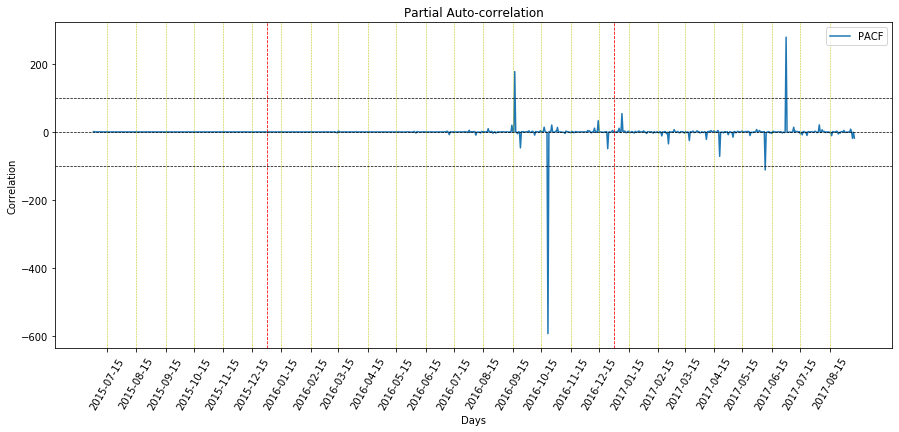

In [17]:
days = len(mean)
ticks      = [ x for x in list(enumerate(mean.index))[:days] if x[1].endswith('-15') ]
ticklabel  = [ x[1] for x in ticks ]
tickloc    = [ x[0] for x in ticks ]

plt.figure(figsize=(15, 6))
acf_plot   = pacf((mean.values), nlags=days)
plt.title('Partial Auto-correlation')
plt.xlabel('Days')
plt.ylabel('Correlation')
plt.plot(np.arange(len(acf_plot)), acf_plot, ls='-')
plt.xticks(tickloc, ticklabel, rotation=60)
plt.legend(['PACF'])
[plt.axvline(x=p, color='y', ls='--', lw=0.5) for p in tickloc]
yearly_ticks = [ x[0] for x in list(enumerate(mean.index))[:days] if x[1].endswith('-12-31') ]
[plt.axvline(x=p, color='r', ls='--', lw=0.8) for p in yearly_ticks]
plt.axhline(y=0,ls='--',lw=0.7, color='black')
#plt.axhline(y=-1.96/np.sqrt(days),linestyle='--',color='gray')
plt.axhline(y=-100,ls='--',lw=0.7, color='black')
#plt.axhline(y=1.96/np.sqrt(days),linestyle='--',color='gray')
plt.axhline(y=100,ls='--',lw=0.7, color='black')
plt.show()

<p>Partial ACF on thecomplete timestamps as seen from above figure shows there is a strong correlation of partial residuals of the lagged values in the Yearly manner. The correlation is not periodic as the peaks do not occur in timely fashion.</p>
<p>Understanding the PACF with Weekly, Monthly, Quarterly and Yearly lagged values.</p>

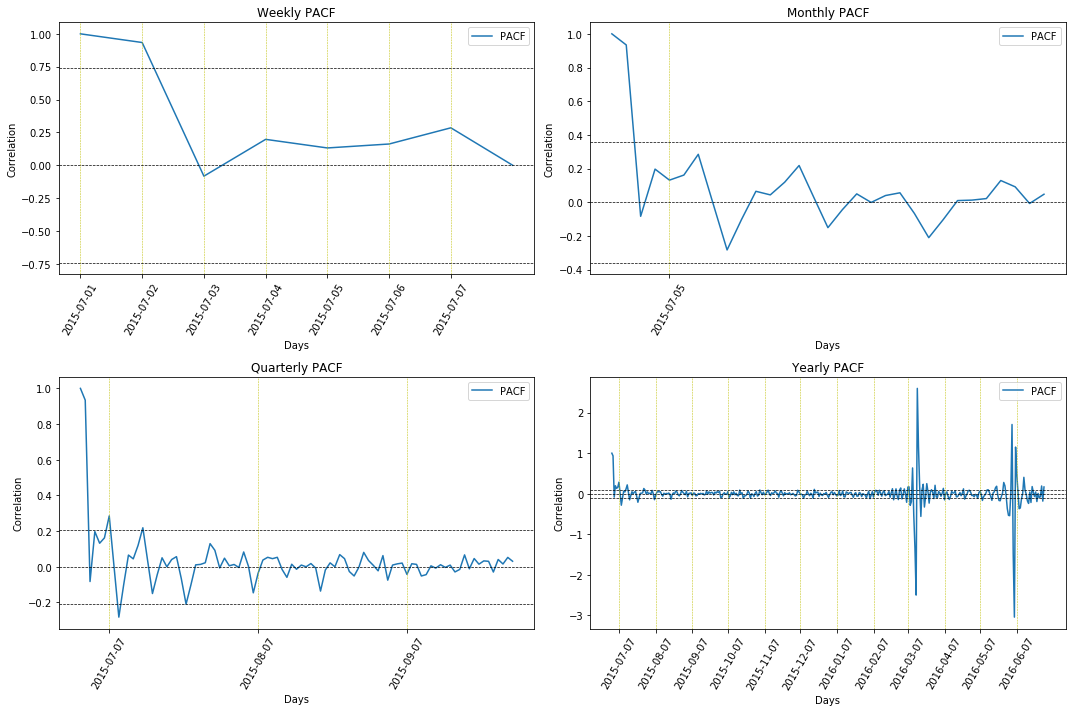

In [18]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(15, 10))


days = 7
ticks      = [ x for x in list(enumerate(mean.index))[:days] ]
ticklabel  = [ x[1] for x in ticks ]
tickloc    = [ x[0] for x in ticks ]
plt.subplot(221)
acf_plot   = pacf((mean.values), nlags=days)
plt.title('Weekly PACF')
plt.xlabel('Days')
plt.ylabel('Correlation')
plt.plot(np.arange(len(acf_plot)), acf_plot, ls='-')
plt.xticks(tickloc, ticklabel, rotation=60)
plt.legend(['PACF'])
[plt.axvline(x=p, color='y', ls='--', lw=0.5) for p in tickloc]
plt.axhline(y=0,ls='--',lw=0.7, color='black')
plt.axhline(y=-1.96/np.sqrt(days),ls='--',lw=0.7, color='black')
plt.axhline(y=1.96/np.sqrt(days),ls='--' ,lw=0.7, color='black')


days = 30

ticks      = [ x for x in list(enumerate(mean.index))[:days] if x[1].endswith('05') ]
ticklabel  = [ x[1] for x in ticks ]
tickloc    = [ x[0] for x in ticks ]
plt.subplot(222)
acf_plot   = pacf((mean.values), nlags=days)
plt.title('Monthly PACF')
plt.xlabel('Days')
plt.ylabel('Correlation')
plt.plot(np.arange(len(acf_plot)), acf_plot, ls='-')
plt.xticks(tickloc, ticklabel, rotation=60)
plt.legend(['PACF'])
[plt.axvline(x=p, color='y', ls='--', lw=0.5) for p in tickloc]
plt.axhline(y=0,ls='--',lw=0.7, color='black')
plt.axhline(y=-1.96/np.sqrt(days),ls='--',lw=0.7, color='black')
plt.axhline(y=1.96/np.sqrt(days),ls='--' ,lw=0.7, color='black')


days = 90

ticks      = [ x for x in list(enumerate(mean.index))[:days] if x[1].endswith('07') ]
ticklabel  = [ x[1] for x in ticks ]
tickloc    = [ x[0] for x in ticks ]
plt.subplot(223)
acf_plot   = pacf((mean.values), nlags=days)
plt.title('Quarterly PACF')
plt.xlabel('Days')
plt.ylabel('Correlation')
plt.plot(np.arange(len(acf_plot)), acf_plot, ls='-')
plt.xticks(tickloc, ticklabel, rotation=60)
plt.legend(['PACF'])
[plt.axvline(x=p, color='y', ls='--', lw=0.5) for p in tickloc]
plt.axhline(y=0,ls='--',lw=0.7, color='black')
plt.axhline(y=-1.96/np.sqrt(days),ls='--',lw=0.7, color='black')
plt.axhline(y=1.96/np.sqrt(days),ls='--' ,lw=0.7, color='black')


days = 365

ticks      = [ x for x in list(enumerate(mean.index))[:days] if x[1].endswith('07') ]
ticklabel  = [ x[1] for x in ticks ]
tickloc    = [ x[0] for x in ticks ]
plt.subplot(224)
acf_plot   = pacf((mean.values), nlags=days)
plt.title('Yearly PACF')
plt.xlabel('Days')
plt.ylabel('Correlation')
plt.plot(np.arange(len(acf_plot)), acf_plot, ls='-')

plt.xticks(tickloc, ticklabel, rotation=60)
plt.legend(['PACF'])
[plt.axvline(x=p, color='y', ls='--', lw=0.5) for p in tickloc]
plt.axhline(y=0,ls='--',lw=0.7, color='black')
plt.axhline(y=-1.96/np.sqrt(days),ls='--',lw=0.7, color='black')
plt.axhline(y=1.96/np.sqrt(days),ls='--' ,lw=0.7, color='black')

plt.tight_layout()
plt.show()

<p>With Weekly, Monthly, Quarterly and Yearly correlation for Mean PageViews of the data.</p>
<p>No significant correlaiton was observed for shorted lag values, i.e. for Weekly, Monthly and Quarterly PACF.</p>
<p>Sharp spike of significant PACF can be observed after 2016-04-07, i.e. after 270 days. With this we can assume that a lag of year can become significant in determining the forecasting.</p>

<p><b>As observed from above, we can see for any trend, seasonality in the data over the span of a year</b></p>

## [2.3] Seasonality of the Data

<p>TIme series of Mean PageViews was not additive i.e. the pageviews doesnot increase with the time, and hence, to check its seasinality, we will be using Multiplicative model to check it's seasonality</p>

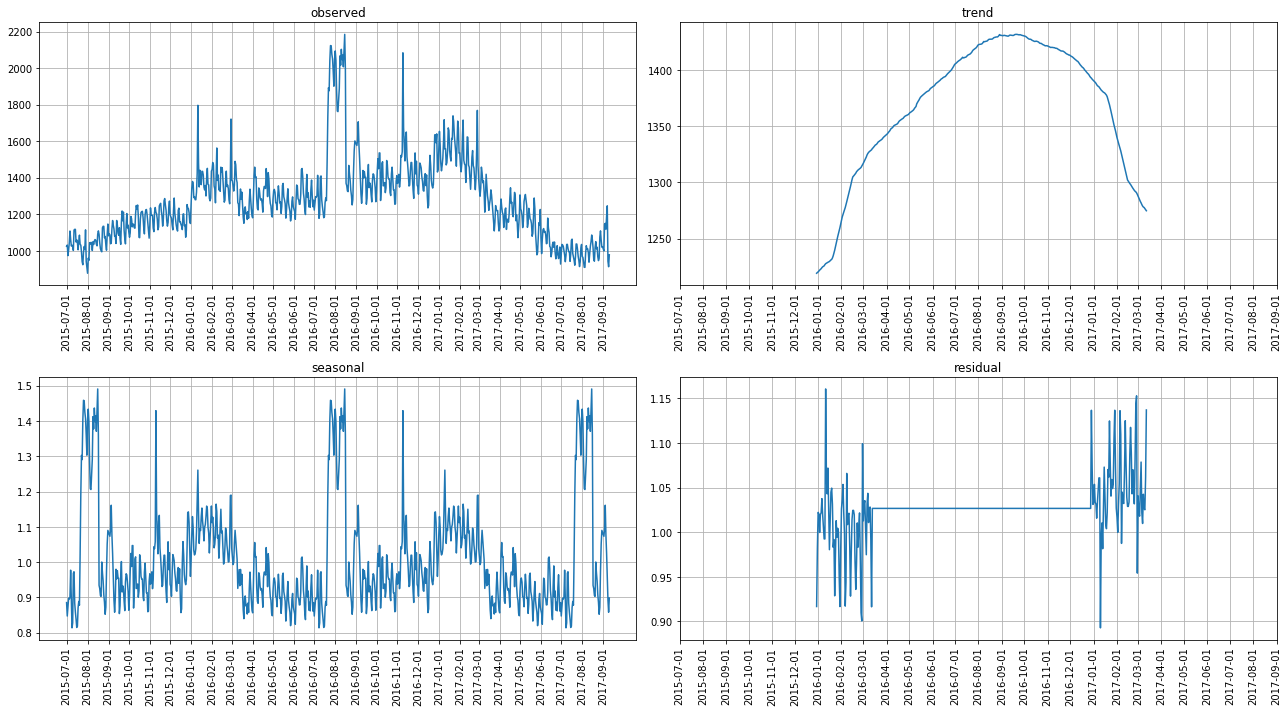

In [19]:
result = seasonal_decompose(mean, model='multiplicative', freq=365)
trend_comp    = result.trend
seasonal_comp = result.seasonal
residual_comp = result.resid
observed_val  = result.observed


ticks      = [ x for x in list(enumerate(result.weights.index))[:] if x[1].split('-')[-1]=='01' ]
ticklabel  = [ x[1] for x in ticks ]
tickloc    = [ x[0] for x in ticks ]

plt.figure(figsize=(18, 10))
plt.title('Seasonal Decomposition of Mean Pageviews of data')
plt.subplot(221)
plt.plot(observed_val)
plt.title('observed')
plt.xticks(tickloc, ticklabel, rotation=90)
plt.grid()

plt.subplot(222)
plt.plot(trend_comp)
plt.title('trend')
plt.xticks(tickloc, ticklabel, rotation=90)
plt.grid()

plt.subplot(223)
plt.plot(seasonal_comp)
plt.title('seasonal')
plt.xticks(tickloc, ticklabel, rotation=90)
plt.grid()

plt.subplot(224)
plt.plot(residual_comp)
plt.title('residual')
plt.xticks(tickloc, ticklabel, rotation=90)
plt.grid()

plt.tight_layout()
plt.show()

<p>From the plot of PACF, we could see negative spike in the data, which can be observed from trend waveform.</p>
<p>With sesonality decomposition of the mean timeseries for all pages, we can see
<li>Trend is decreasing after a certain increase in the initial period.</li>
<li>yearly cycle is observed in the data</li>
</p>

## [2.2] Rolling Mean

<p>Rolling Statistics is mainly used to check the volatility in the data over the time interval</p>

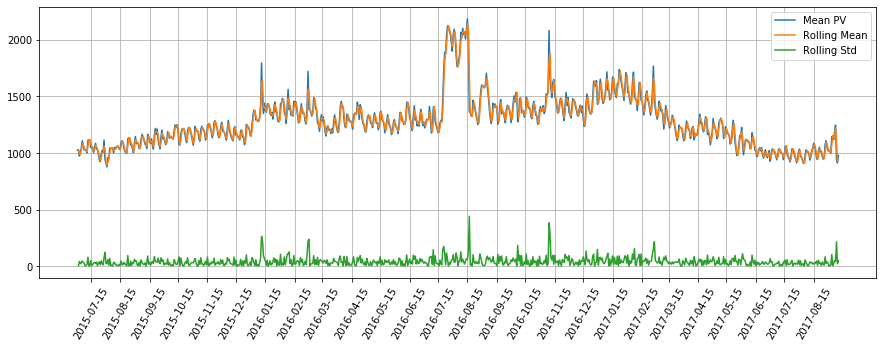

In [20]:
wndw = 2
plt.figure(figsize=(15,5))
b1 = plt.plot(mean)
b2 = plt.plot(mean.rolling(window=wndw).mean().dropna())
b3 = plt.plot(mean.rolling(window=wndw).std().dropna())

ticks      = [ x for x in list(enumerate(mean.index))[:] if x[1].endswith('15') ]
ticklabel  = [ x[1] for x in ticks ]
tickloc    = [ x[0] for x in ticks ]
plt.xticks(tickloc, ticklabel, rotation=60)
plt.legend([b1[0], b2[0], b3[0]], ['Mean PV', 'Rolling Mean', 'Rolling Std'])
plt.grid()
plt.show()

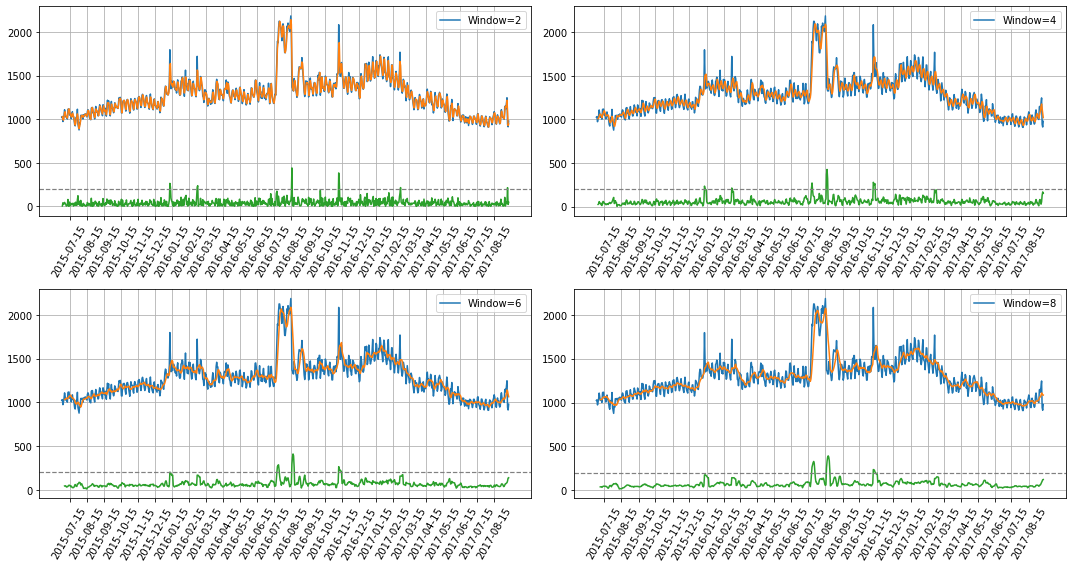

In [21]:
plt.figure(figsize=(15, 8))

plt.subplot(221)
b1 = plt.plot(mean)
b2 = plt.plot(mean.rolling(window=2).mean().dropna())
b3 = plt.plot(mean.rolling(window=2).std().dropna())
plt.axhline(y=200, ls='--', color='gray', lw=1.2)
plt.xticks(tickloc, ticklabel, rotation=60)
plt.grid()
plt.legend(['Window=2'])

plt.subplot(222)
b1 = plt.plot(mean)
b2 = plt.plot(mean.rolling(window=4).mean().dropna())
b3 = plt.plot(mean.rolling(window=4).std().dropna())
plt.axhline(y=200, ls='--', color='gray', lw=1.2)
plt.xticks(tickloc, ticklabel, rotation=60)
plt.grid()
plt.legend(['Window=4'])

plt.subplot(223)
b1 = plt.plot(mean)
b2 = plt.plot(mean.rolling(window=6).mean().dropna())
b3 = plt.plot(mean.rolling(window=6).std().dropna())
plt.axhline(y=200, ls='--', color='gray', lw=1.2)
plt.xticks(tickloc, ticklabel, rotation=60)
plt.grid()
plt.legend(['Window=6'])

plt.subplot(224)
b1 = plt.plot(mean)
b2 = plt.plot(mean.rolling(window=8).mean().dropna())
b3 = plt.plot(mean.rolling(window=8).std().dropna())
plt.axhline(y=200, ls='--', color='gray', lw=1.2)
plt.xticks(tickloc, ticklabel, rotation=60)
plt.grid()
plt.legend(['Window=8'])

plt.tight_layout()
plt.show()

<p>Higher variance was observed for smaller lagged values for Mean Pageviews.</p>
<p>Variance reduces as the window size increases but then the smoothed Mean is way to off from the actual observations in this case. Considering correlation, we see that the values were strongly dependent on the previous values but we cannot increase the window size as this might increase the error term while forecasting the values as seen from above plots</p>

# [3] Data Preparation

In [22]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

In [23]:
print("Starting Data : {0} and Ending Date : {1} which makes total of {2} days data."\
      .format(timeseries.columns.tolist()[0], timeseries.columns.tolist()[-1], len(timeseries.columns.tolist())))

Starting Data : 2015-07-01 and Ending Date : 2017-09-10 which makes total of 803 days data.


<p>As we have total of 803 days, we will be doing modeling on 2 years data i.e. from 2015-07-01 to 2017-07-01. This will be considered to be traning data and the remaining data will be considered to be test data, i.e. from 2017-07-02 to 2017-09-10.</p>

In [24]:
#finding the index of the train end
date_cols  = timeseries.columns.tolist()
train_end  = date_cols.index('2017-07-01')-1

In [25]:
train_data = timeseries.iloc[:,:train_end]
test_data  = timeseries.iloc[:,train_end:]

print("Train data shape is :{0}, \nTest data shape is :{1}, \nwhich was derived from main data having size :{2}"\
      .format(train_data.shape, test_data.shape, train.shape))

Train data shape is :(145063, 730), 
Test data shape is :(145063, 73), 
which was derived from main data having size :(145063, 804)


Page Name is also important feature and hence we will be getting the features for each page along with the timeseries.

In [26]:
#train data preparation
train_data               = train_data.join(pageData, how='left')

train_data['Site_OHE']   = label.fit_transform(train_data['Site_Name']).tolist()
print("Site ENcoded using     : ", label.classes_)

train_data['Lang_OHE']   = label.fit_transform(train_data['Language']).tolist()
print("Language Encoded using : ", label.classes_)

train_data['Access_OHE'] = label.fit_transform(train_data['Access']).tolist()
print("Access Encoded using   : ", label.classes_)

train_data['Agent_OHE']  = label.fit_transform(train_data['Agent']).tolist()
print("Agent Encoded using    : ", label.classes_)

train_data.drop(['Page', 'Site', 'Site_Name', 'Language', 'Access', 'Agent'], axis=1, inplace=True)
train_data = train_data.rename(columns={timeseries.iloc[:,:train_end].columns[-1]:'Observed'})
train_data.to_csv('./train_data.csv')

Site ENcoded using     :  ['mediawiki' 'wikimedia' 'wikipedia']
Language Encoded using :  ['commons' 'de' 'en' 'es' 'fr' 'ja' 'ru' 'www' 'zh']
Access Encoded using   :  ['all-access' 'desktop' 'mobile-web']
Agent Encoded using    :  ['all-agents' 'spider']


In [27]:
train_data.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-06-24,2017-06-25,2017-06-26,2017-06-27,2017-06-28,Observed,Site_OHE,Lang_OHE,Access_OHE,Agent_OHE
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,21.0,23.0,23.0,32.0,34.0,21.0,2,8,0,1
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,193.0,26.0,62.0,127.0,104.0,20.0,2,8,0,1
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,5.0,4.0,4.0,5.0,5.0,0.0,2,8,0,1
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,12.0,11.0,12.0,10.0,22.0,21.0,2,8,0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,12.0,10.0,21.0,14.0,9.0,2,8,0,1


In [28]:
#test data preparation
test_data               = test_data.join(pageData, how='left')

test_data['Site_OHE']   = label.fit_transform(test_data['Site_Name']).tolist()
print("Site ENcoded using     : ", label.classes_)

test_data['Lang_OHE']   = label.fit_transform(test_data['Language']).tolist()
print("Language Encoded using : ", label.classes_)

test_data['Access_OHE'] = label.fit_transform(test_data['Access']).tolist()
print("Access Encoded using   : ", label.classes_)

test_data['Agent_OHE']  = label.fit_transform(test_data['Agent']).tolist()
print("Agent Encoded using    : ", label.classes_)

test_data.drop(['Page', 'Site', 'Site_Name', 'Language', 'Access', 'Agent'], axis=1, inplace=True)
test_data.to_csv('./test_data.csv')


Site ENcoded using     :  ['mediawiki' 'wikimedia' 'wikipedia']
Language Encoded using :  ['commons' 'de' 'en' 'es' 'fr' 'ja' 'ru' 'www' 'zh']
Access Encoded using   :  ['all-access' 'desktop' 'mobile-web']
Agent Encoded using    :  ['all-agents' 'spider']


In [29]:
test_data.head()

,2017-06-30,2017-07-01,2017-07-02,2017-07-03,2017-07-04,2017-07-05,2017-07-06,2017-07-07,2017-07-08,2017-07-09,...,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,Site_OHE,Lang_OHE,Access_OHE,Agent_OHE
0,24.0,23.0,24.0,26.0,15.0,14.0,15.0,19.0,29.0,22.0,...,16.0,27.0,29.0,23.0,54.0,38.0,2,8,0,1
1,29.0,15.0,26.0,16.0,23.0,19.0,16.0,816.0,20.0,76.0,...,54.0,25.0,26.0,23.0,13.0,81.0,2,8,0,1
2,6.0,1.0,1.0,7.0,1.0,1.0,1.0,10.0,1.0,2.0,...,4.0,7.0,3.0,4.0,7.0,6.0,2,8,0,1
3,30.0,7.0,19.0,16.0,10.0,17.0,15.0,22.0,6.0,6.0,...,6.0,16.0,19.0,30.0,38.0,4.0,2,8,0,1
4,12.0,12.0,16.0,6.0,16.0,18.0,12.0,14.0,11.0,16.0,...,20.0,23.0,28.0,14.0,8.0,7.0,2,8,0,1


In [30]:
#saving pagedata for future reference.
pageData.to_csv('./page_data.csv')

# [4] Conclusion

<p><b>Overview of EDA</b></p>
<p>As from timeseries, we can conclude, current pageviews of each page strongly correlated with their previous values</p>
<p>With the extracted features from Page Name, we can see Language, Site Name, Acess and Agent can be the important features in the forecasting the future values of each page.</p>

<p><b>Idea for Modeling</b></p>
<p><li>Train Modeling</li>Considering last pageview of the train data as the Observed value from the past timeseries, we can actually train the regressor models to  fit itself on the data to learn the weights to predict the Observed value. This fitting of model will help understand the trend and seasonality of the data through modeling.</p>
<p><li>Test Modeling</li>With the available weights of the model, for each point of the test, we will pass lagged values so as to predict pageview for each page for each day in Test set.</p>
<p>Considering timely nature of the data, we can make use of DL models which are mainly the RNN and CNN models, which learn the pattern in the data on itself (with the base logic) to predict the future value</p>